In [33]:
from sentinelhub import SHConfig
from sentinelhub import SentinelHubCatalog

import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
from shapely.ops import unary_union
from fiona.drvsupport import supported_drivers
import geopandas as gpd
from matplotlib.path import Path
from shapely.geometry import Polygon
import earthpy.spatial as es
import earthpy.plot as ep
import numpy.ma as ma
from scipy.stats.mstats import gmean, hmean

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image

colors = ['tomato', 'navy', 'MediumSpringGreen', 'lightblue', 'orange', 'blue',
          'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan']

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
CLIENT_ID = os.getenv('CLIENT_ID')
CLIENT_SECRET = os.environ.get('CLIENT_SECRET')

config = SHConfig()

if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

In [34]:
catalog = SentinelHubCatalog(config=config)

catalog.get_info()

{'type': 'Catalog',
 'stac_version': '1.0.0',
 'id': 'sentinel-hub',
 'title': 'Sentinel Hub STAC catalog',
 'description': 'STAC v1.0.0 implementation by Sentinel Hub',
 'conformsTo': ['http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/core',
  'http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/oas30',
  'http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/geojson',
  'https://api.stacspec.org/v1.0.0-rc.2/core',
  'https://api.stacspec.org/v1.0.0-rc.2/collections',
  'https://api.stacspec.org/v1.0.0-rc.2/ogcapi-features',
  'https://api.stacspec.org/v1.0.0-rc.2/ogcapi-features#fields',
  'https://api.stacspec.org/v1.0.0-rc.2/ogcapi-features#context',
  'https://api.stacspec.org/v1.0.0-rc.2/ogcapi-features#filter',
  'https://api.stacspec.org/v1.0.0-rc.2/item-search',
  'https://api.stacspec.org/v1.0.0-rc.2/item-search#fields',
  'https://api.stacspec.org/v1.0.0-rc.2/item-search#context',
  'https://api.stacspec.org/v1.0.0-rc.2/item-search#filter',
  'http://www.opengis.ne

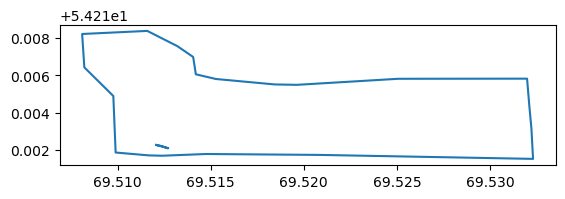

In [5]:
supported_drivers['KML'] = 'rw'
pasture_df = gpd.read_file('pasture.kml', driver='KML')

all_zagons = []
for zagon in range(len(pasture_df.index)):
    all_zagons.append(pasture_df.loc[zagon].geometry)
    
merged_zagons = unary_union(all_zagons)

gpd.GeoSeries([merged_zagons]).boundary.plot()
plt.show()

In [6]:
x_min, y_min, x_max, y_max = merged_zagons.bounds
betsiboka_coords_wgs84 = (x_min, y_min, x_max, y_max)

In [7]:
resolution = 10
betsiboka_bbox = BBox(bbox=betsiboka_coords_wgs84, crs=CRS.WGS84)
betsiboka_size = bbox_to_dimensions(betsiboka_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {betsiboka_size} pixels")

Image shape at 10 m resolution: (157, 78) pixels


In [28]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

In [8]:
evalscript_all_bands = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"],
                units: "DN"
            }],
            output: {
                bands: 13,
                sampleType: "INT16"
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B01,
                sample.B02,
                sample.B03,
                sample.B04,
                sample.B05,
                sample.B06,
                sample.B07,
                sample.B08,
                sample.B8A,
                sample.B09,
                sample.B10,
                sample.B11,
                sample.B12];
    }
"""

request_all_bands = SentinelHubRequest(
    evalscript=evalscript_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2020-06-01", "2020-06-30"),
            mosaicking_order=MosaickingOrder.LEAST_CC,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config,
)

In [9]:
all_bands_response = request_all_bands.get_data()

In [10]:
print(f"Returned data is of type = {type(all_bands_response)} and length {len(all_bands_response)}.")
print(f"Single element in the list is of type {type(all_bands_response[-1])} and has shape {all_bands_response[-1].shape}")

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (78, 157, 13)


In [13]:
 aoi_height, aoi_width, _ = all_bands_response[-1].shape

In [14]:
masks = []
pasture_edges = []
for zagon in range(len(pasture_df)-1):
    polygon=[]

    for coords in pasture_df.loc[zagon].geometry.exterior.coords:

        x = int(np.interp(coords[0], [x_min, x_max], [0, aoi_width]))
        y = int(np.interp(coords[1], [y_min, y_max], [aoi_height, 0]))

        polygon.append((y, x))
        
    poly_path=Path(polygon)
    x, y = np.mgrid[:aoi_height, :aoi_width]
    coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1)))
    
    pasture_edges.append(Polygon(polygon))
    
    mask = ~poly_path.contains_points(coors)
    masks.append(mask)

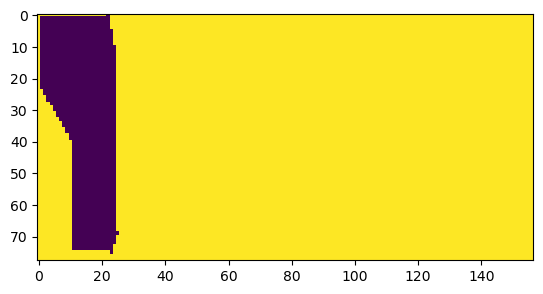

In [15]:
plt.imshow(masks[0].reshape(aoi_height, aoi_width))
plt.show()

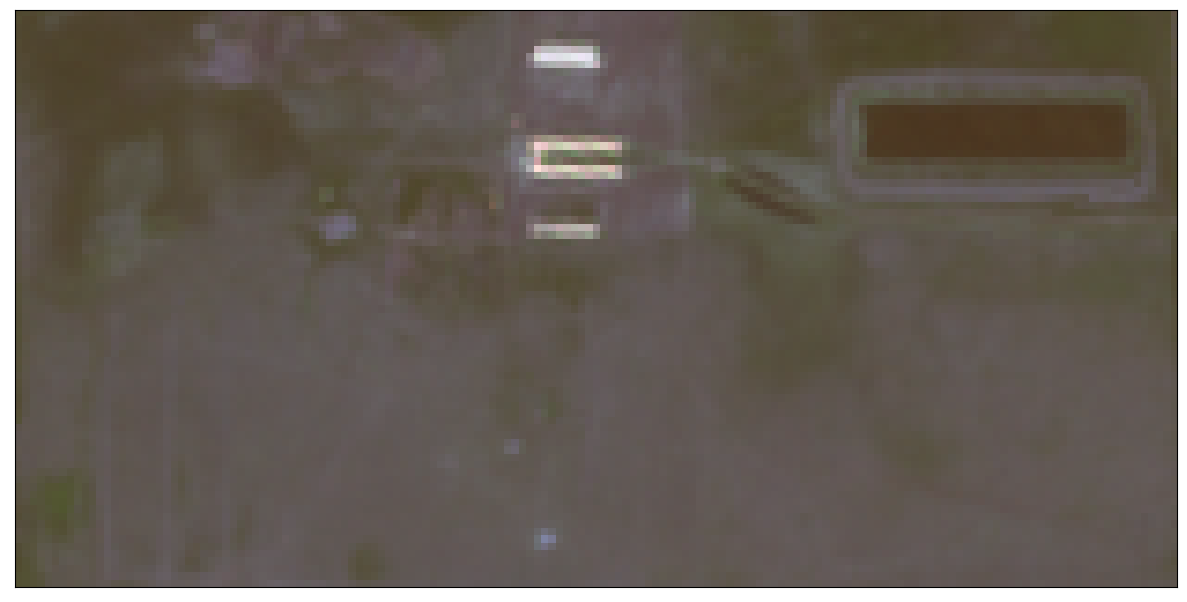

In [16]:
plot_image(all_bands_response[0][:, :, [1, 2, 3]], factor = 3.5 / 1e4, clip_range=(0, 1))

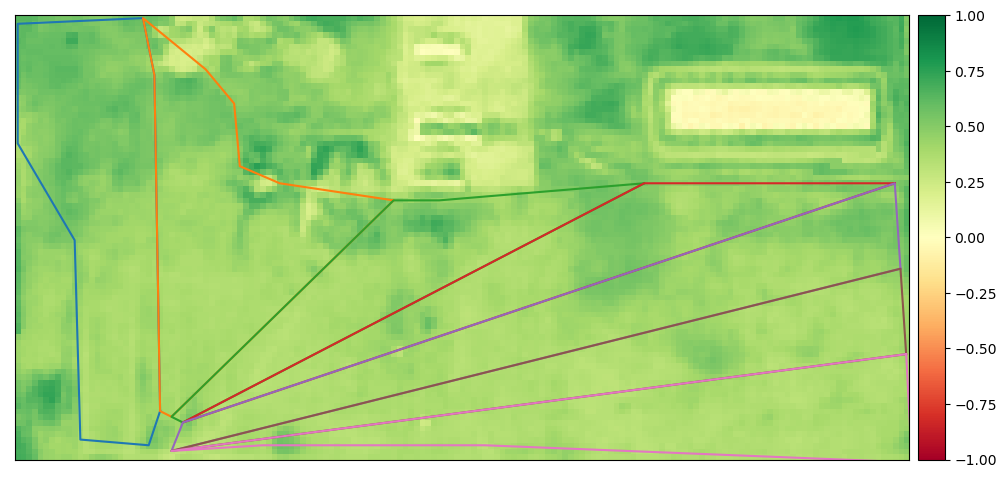

In [17]:
fig, ax = plt.subplots(figsize=(12, 12))
for zagon in range(len(pasture_df)-1):
    
    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

ndvi = es.normalized_diff(all_bands_response[0][:, :, 7], all_bands_response[0][:, :, 3])
ep.plot_bands(ndvi, ax=ax, cmap="RdYlGn", cols=1, vmin=-1, vmax=1, figsize=(10, 14))

plt.show()

In [18]:
ndvi_masked_array = []
for i, mask in enumerate(masks):
    mx = ma.masked_array(ndvi, mask=mask.reshape(aoi_height, aoi_width))
    ndvi_masked_array.append(mx)

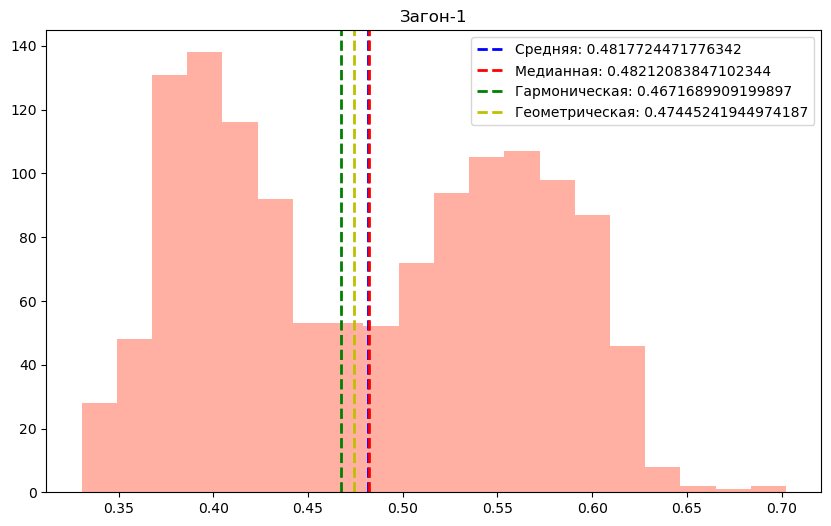

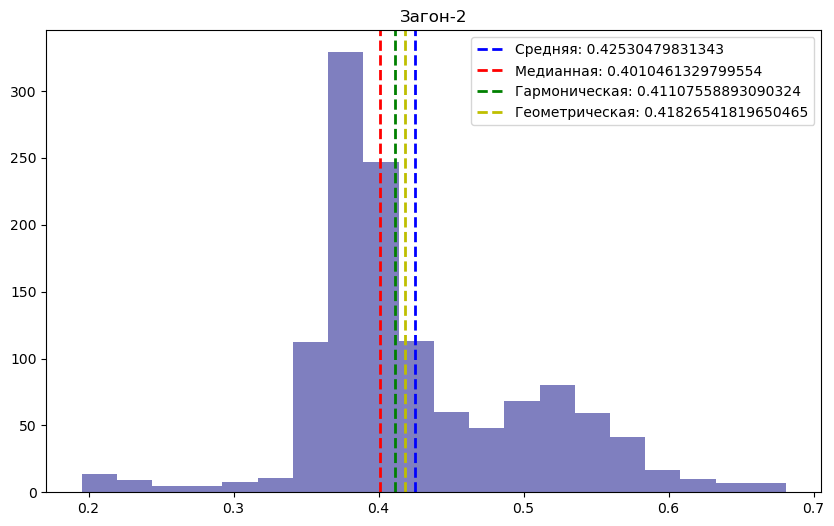

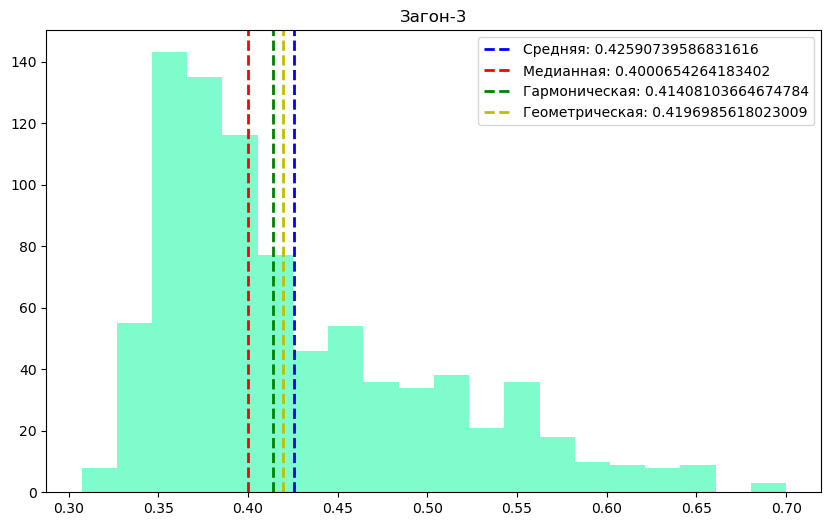

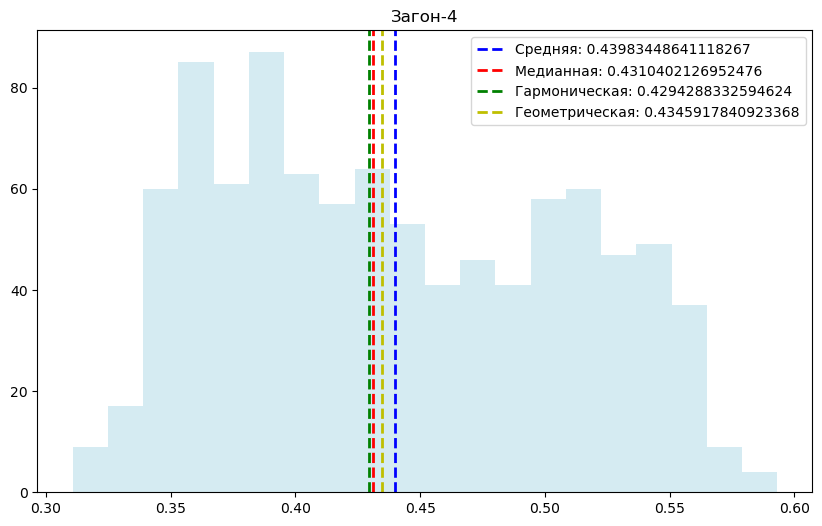

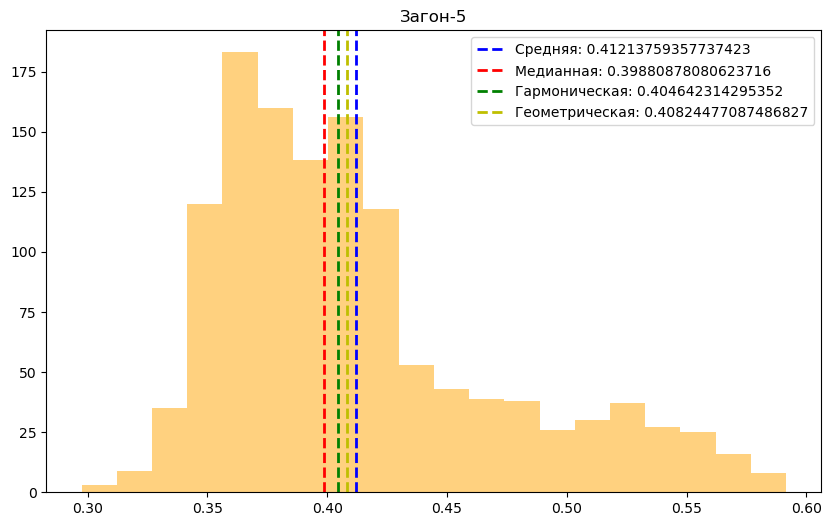

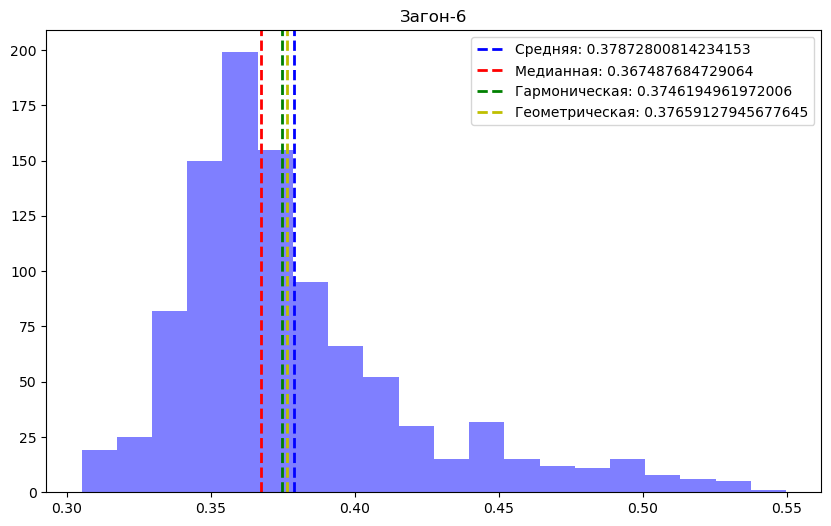

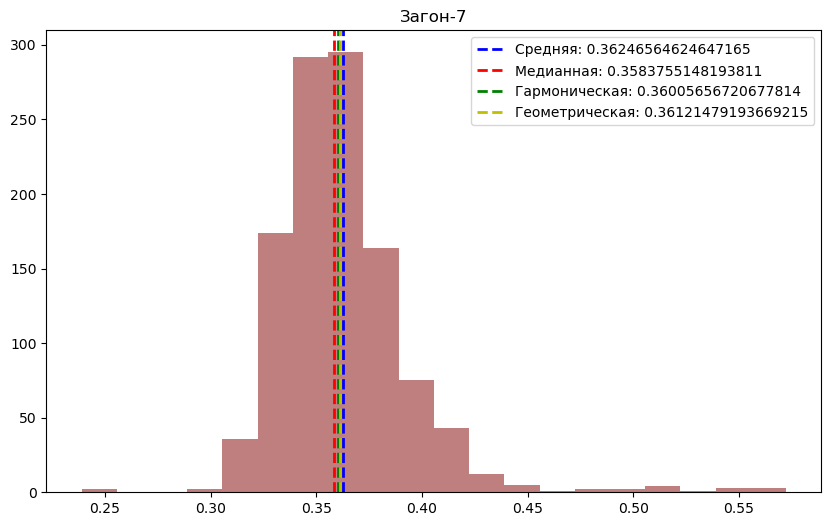

In [19]:
for i, zagon in enumerate(ndvi_masked_array):
    ep.hist(zagon, colors = colors[i], title=f'Загон-{i+1}', cols=4, alpha=0.5, 
    figsize = (10, 6))
    plt.axvline(ndvi_masked_array[i].mean(), color='b', linestyle='dashed', linewidth=2)
    plt.axvline(ma.median(ndvi_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
    plt.axvline(hmean(ndvi_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
    plt.axvline(gmean(ndvi_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
    plt.legend([f"Средняя: {ndvi_masked_array[i].mean()}",f"Медианная: {ma.median(ndvi_masked_array[i])}",f"Гармоническая: {hmean(ndvi_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(ndvi_masked_array[i].reshape(aoi_width * aoi_height))}"])
plt.show()

In [20]:
print("Supported DataCollections:\n")
for collection in DataCollection.get_available_collections():
    print(collection)

Supported DataCollections:

DataCollection.SENTINEL2_L1C
DataCollection.SENTINEL2_L2A
DataCollection.SENTINEL1
DataCollection.SENTINEL1_IW
DataCollection.SENTINEL1_IW_ASC
DataCollection.SENTINEL1_IW_DES
DataCollection.SENTINEL1_EW
DataCollection.SENTINEL1_EW_ASC
DataCollection.SENTINEL1_EW_DES
DataCollection.SENTINEL1_EW_SH
DataCollection.SENTINEL1_EW_SH_ASC
DataCollection.SENTINEL1_EW_SH_DES
DataCollection.DEM
DataCollection.DEM_MAPZEN
DataCollection.DEM_COPERNICUS_30
DataCollection.DEM_COPERNICUS_90
DataCollection.MODIS
DataCollection.LANDSAT_MSS_L1
DataCollection.LANDSAT_TM_L1
DataCollection.LANDSAT_TM_L2
DataCollection.LANDSAT_ETM_L1
DataCollection.LANDSAT_ETM_L2
DataCollection.LANDSAT_OT_L1
DataCollection.LANDSAT_OT_L2
DataCollection.SENTINEL5P
DataCollection.SENTINEL3_OLCI
DataCollection.SENTINEL3_SLSTR
DataCollection.HARMONIZED_LANDSAT_SENTINEL


In [22]:
start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2019, 12, 31)
n_chunks = 70
tdelta = (end - start) / n_chunks
edges = [(start + i * tdelta).date().isoformat() for i in range(n_chunks)]
slots = [(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]

print(f"Monthly time windows: {len(slots)}\n")
for slot in slots:
    print(slot)

Monthly time windows: 69

('2019-01-01', '2019-01-06')
('2019-01-06', '2019-01-11')
('2019-01-11', '2019-01-16')
('2019-01-16', '2019-01-21')
('2019-01-21', '2019-01-27')
('2019-01-27', '2019-02-01')
('2019-02-01', '2019-02-06')
('2019-02-06', '2019-02-11')
('2019-02-11', '2019-02-16')
('2019-02-16', '2019-02-22')
('2019-02-22', '2019-02-27')
('2019-02-27', '2019-03-04')
('2019-03-04', '2019-03-09')
('2019-03-09', '2019-03-14')
('2019-03-14', '2019-03-20')
('2019-03-20', '2019-03-25')
('2019-03-25', '2019-03-30')
('2019-03-30', '2019-04-04')
('2019-04-04', '2019-04-09')
('2019-04-09', '2019-04-15')
('2019-04-15', '2019-04-20')
('2019-04-20', '2019-04-25')
('2019-04-25', '2019-04-30')
('2019-04-30', '2019-05-05')
('2019-05-05', '2019-05-11')
('2019-05-11', '2019-05-16')
('2019-05-16', '2019-05-21')
('2019-05-21', '2019-05-26')
('2019-05-26', '2019-05-31')
('2019-05-31', '2019-06-06')
('2019-06-06', '2019-06-11')
('2019-06-11', '2019-06-16')
('2019-06-16', '2019-06-21')
('2019-06-21', '2

In [29]:
def get_true_color_request(time_interval):
    return SentinelHubRequest(
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=time_interval,
                mosaicking_order=MosaickingOrder.LEAST_CC,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=betsiboka_bbox,
        size=betsiboka_size,
        config=config,
    )

In [30]:
# create a list of requests
list_of_requests = [get_true_color_request(slot) for slot in slots]
list_of_requests = [request.download_list[0] for request in list_of_requests]

# download data with multiple threads
data = SentinelHubDownloadClient(config=config).download(list_of_requests, max_threads=5)

In [31]:
# some stuff for pretty plots
ncols = 10
nrows = 10
aspect_ratio = betsiboka_size[0] / betsiboka_size[1]
subplot_kw = {"xticks": [], "yticks": [], "frame_on": False}

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols * aspect_ratio, 5 * nrows), subplot_kw=subplot_kw)

for idx, image in enumerate(data):
    ax = axs[idx // ncols][idx % ncols]
    ax.imshow(np.clip(image * 2.5 / 255, 0, 1))
    ax.set_title(f"{slots[idx][0]}  -  {slots[idx][1]}", fontsize=10)

plt.tight_layout()

In [47]:
time_interval = "2020-06-01", "2020-06-30"

search_iterator = catalog.search(
    DataCollection.SENTINEL2_L1C,
    bbox=betsiboka_bbox,
    time=time_interval,
    filter="eo:cloud_cover < 20",
    fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
)

results = list(search_iterator)
print("Total number of results:", len(results))

results

Total number of results: 3


[{'id': 'S2B_MSIL1C_20200616T062629_N0209_R077_T42UWF_20200616T083407',
  'properties': {'datetime': '2020-06-16T06:34:09Z', 'eo:cloud_cover': 1.81}},
 {'id': 'S2B_MSIL1C_20200609T063629_N0209_R120_T42UWF_20200609T094548',
  'properties': {'datetime': '2020-06-09T06:44:06Z', 'eo:cloud_cover': 2.92}},
 {'id': 'S2B_MSIL1C_20200606T062629_N0209_R077_T42UWF_20200606T083340',
  'properties': {'datetime': '2020-06-06T06:34:09Z', 'eo:cloud_cover': 0.25}}]

In [48]:
from sentinelhub import MimeType, SentinelHubDownloadClient, SentinelHubRequest, bbox_to_dimensions, filter_times
import datetime as dt

time_difference = dt.timedelta(hours=1)

all_timestamps = search_iterator.get_timestamps()
unique_acquisitions = filter_times(all_timestamps, time_difference)

unique_acquisitions

[datetime.datetime(2020, 6, 6, 6, 34, 9, tzinfo=tzutc()),
 datetime.datetime(2020, 6, 9, 6, 44, 6, tzinfo=tzutc()),
 datetime.datetime(2020, 6, 16, 6, 34, 9, tzinfo=tzutc())]

In [52]:
false_color_evalscript = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""


process_requests = []

for timestamp in unique_acquisitions:
    request = SentinelHubRequest(
        evalscript=false_color_evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=(timestamp - time_difference, timestamp + time_difference),
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
        bbox=betsiboka_bbox,
        size=betsiboka_size,
        config=config,
    )
    process_requests.append(request)

In [53]:
%%time

client = SentinelHubDownloadClient(config=config)

download_requests = [request.download_list[0] for request in process_requests]

data = client.download(download_requests)

data[0].shape

Wall time: 1.58 s


(78, 157, 3)

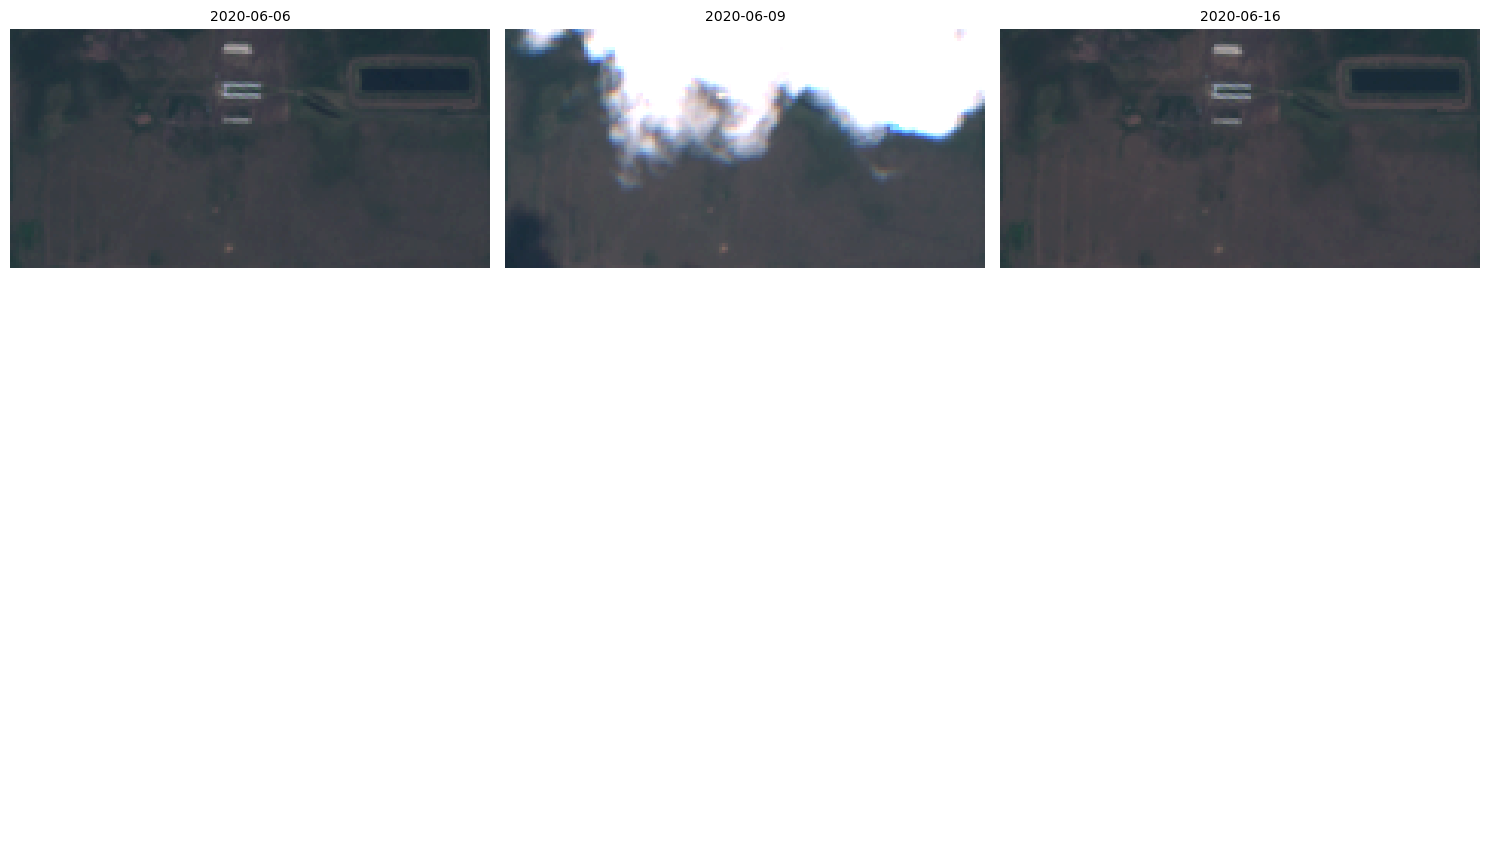

In [54]:
ncols, nrows = 3, 2

fig, axis = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(15, 10), subplot_kw={"xticks": [], "yticks": [], "frame_on": False}
)

for idx, (image, timestamp) in enumerate(zip(data, unique_acquisitions)):
    ax = axis[idx // ncols][idx % ncols]
    ax.imshow(np.clip(image * 2.5 / 255, 0, 1))
    ax.set_title(timestamp.date().isoformat(), fontsize=10)

plt.tight_layout()

In [58]:
l = ["111", "efs", "effe", "fesfs", "fe"]

In [59]:
counter = 0
for i in l:
    print(i)
    counter += 1

111
efs
effe
fesfs
fe
